# Basic Models in TensorFlow 

## Linear regression in TensorFlow
- Model the linear relationship between
    + dependent variable Y, explanatory variables X 
    + Find a linear relationship between X and Y to predict Y from X 
- Inference: Y_predicted = w * X +b

### Linear Regression with huber loss by high-level
- Huber loss 
    + Robust to ouliers 
    + If the difference between the predicted value and the real value is small, square it
    + If it's large, take its absolute value
- Implementing Huber loss 
    + tf.losses.huber_loss

#### Setup 

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

1.11.0


#### Load and Pre-process data 

In [2]:
# Read in data
data = pd.read_table('../data/birth_life_2010.txt')
data.head()

,Country,Birth rate,Life expectancy
0,Vietnam,1.822,74.828244
1,Vanuatu,3.869,70.819488
2,Tonga,3.911,72.150659
3,Timor-Leste,5.578,61.999854
4,Thailand,1.579,73.927659


In [3]:
x = data.loc[:, 'Birth rate'].values
y = data.loc[:, 'Life expectancy'].values
print(x.shape, y.shape)

(190,) (190,)


In [4]:
# Split train and validation 
# 190개에서 0.7= 133개 선택(idex)
tr_indices = np.random.choice(range(x.shape[0]), size = int(x.shape[0] * .7), replace=False)
print('tr_indices: {}'.format(tr_indices))

tr_indices: [ 33 146  34  63  60 132 181  50  27 101  57 139  46 153 159  31 119  87
 169 106  48 118  30 187  24 115 142  13  26 141  83 123 171  11 140  37
 172  81  78  14 188  89 117  49 156 160 112  67  10  16 107  90 178 110
   0  53  38   7 116 161   2 168  51  92 109  94 136  80  91   3 131 137
 105  29 162  59  55 144  69 100  73  62 102 182 166  75 165  99  66 150
  84 147 151  19 157  72 143  47   4 111  44 170 145  28 158 103 155 125
  25  54 167  61  58  93 175  70  12 114 154 129  82  36 126  23 176 185
 128   9 149 104  79  22 186]


In [5]:
x_tr = x[tr_indices]
y_tr = y[tr_indices]

x_val = np.delete(x, tr_indices, axis=0)
y_val = np.delete(y, tr_indices, axis=0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(133,) (133,)
(57,) (57,)


#### Define the graph of Simple Linear Regression 

In [6]:
# Create placeholders for inputs(X, birth rate) and labels(Y, life expectancy)
X = tf.placeholder(dtype=tf.float32, shape=[None], name='input')
Y = tf.placeholder(dtype=tf.float32, shape=[None], name='label')

# Createweight and bias
w = tf.get_variable(name='weight', initializer=tf.constant(.0))
b = tf.get_variable(name='bias', initializer=tf.constant(.0))

# Inference: Construct model to predict Y
y_predicted = X * w + b

# Specify loss function
# Use the square error as huber loss function
huber_loss = tf.losses.huber_loss(labels=Y, predictions=y_predicted, delta=14.)
huber_loss_summ = tf.summary.scalar(name='huber_loss', tensor=huber_loss)

# Create optimizer
# Using gradient descent with learning rate of 0.01 to minimize loss 
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(huber_loss)

#### Training 
1. Initialize variables 
2. Run optimizer

In [7]:
epochs = 100
batch_size = 8
total_step = int(x.shape[0] / batch_size)
print(total_step)

23


In [10]:
train_writer = tf.summary.FileWriter(logdir='../graphs/lec03/linreg_huber_high_tf_placeholder/train',
                                    graph=tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir='../graphs/lec03/linreg_huber_high_tf_placeholder/val',
                                  graph=tf.get_default_graph())

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):#epoch = 100
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):#total_step = 23 
        # batch_indices = 133개 중에 8개씩 
        batch_indices = np.random.choice(range(x_tr.shape[0]),
                                        size=batch_size, replace=False)
        val_indices = np.random.choice(range(x_val.shape[0]),
                                      size=batch_size, replace=False)
        batch_xs = x_tr[batch_indices]
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss = sess.run(fetches=[training_op, huber_loss],
                             feed_dict={X: batch_xs, Y: batch_ys})
        tr_loss_summ = sess.run(huber_loss_summ, feed_dict={X: batch_xs, Y: batch_ys})
        
        val_loss, val_loss_summ = sess.run(fetches=[huber_loss, huber_loss_summ],
                                         feed_dict={X: val_xs, Y: val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    train_writer.add_summary(tr_loss_summ, global_step=epoch)
    val_writer.add_summary(val_loss_summ, global_step=epoch)
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print('epoch : {:3}, tr_loss: {:.2f}, val_loss: {:.2f}'.format(epoch, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

epoch :   0, tr_loss: 674.18, val_loss: 690.99
epoch :  10, tr_loss: 338.12, val_loss: 267.04
epoch :  20, tr_loss: 256.70, val_loss: 221.79
epoch :  30, tr_loss: 191.24, val_loss: 154.48
epoch :  40, tr_loss: 121.16, val_loss: 108.16
epoch :  50, tr_loss: 72.91, val_loss: 57.73
epoch :  60, tr_loss: 39.60, val_loss: 30.80
epoch :  70, tr_loss: 28.69, val_loss: 20.18
epoch :  80, tr_loss: 21.45, val_loss: 14.58
epoch :  90, tr_loss: 18.98, val_loss: 11.34


#### Visualization

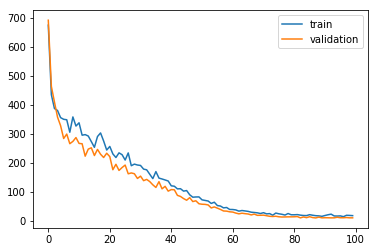

In [12]:
plt.plot(tr_loss_hist, label='train')
plt.plot(val_loss_hist, label='validation')
plt.legend()

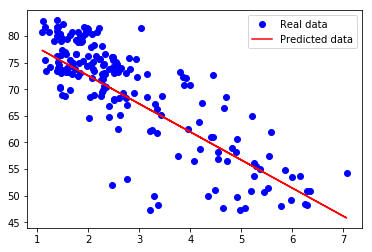

In [13]:
w_out, b_out = sess.run([w, b])
plt.plot(data.iloc[:,1], data.iloc[:,2], 'bo', label='Real data')
plt.plot(data.iloc[:,1], data.iloc[:,1] * w_out + b_out, 'r', label='Predicted data')
plt.legend()